# 參數設定 (使用訊號分解 EMD)

In [1]:
import os

labels = ['GroupCount']
model_type = 2 # 使用模型
predicteds = [5] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = True # 是否使用 EMD，False 則使用 EEMD 
 
model_dir = 'DecompEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: DecompEMD/_Model/GroupCount_mt2_data5_batch14.x_scaler.pkl
y_scaler_file_name: DecompEMD/_Model/GroupCount_mt2_data5_batch14.y_scaler.pkl
model_file_name: DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.keras
result_file_name: DecompEMD/_Model/GroupCount_mt2_data5_batch14.result.json
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.result.json 存在，已刪除


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[5],156009964,1063367,873569,9,2531,64,2604,0,0,0,0,0,0,2604
1,2023-04-03,[5],266983699,1670644,1289435,33,3928,75,4034,2,0,0,0,0,0,4036
2,2023-04-04,[5],198064713,1377806,881103,8,3552,72,3630,2,0,0,0,0,0,3632
3,2023-04-05,[5],275355693,1804631,1005218,8,4270,101,4378,1,0,0,0,0,0,4379
4,2023-04-06,[5],226168175,2059599,1254506,40,5491,82,5612,0,0,0,1,0,0,5613


# 訊號分解

# 訊號分解
EMD
IMFs shape : (7, 395)
eIMFs shape : (6, 395)
residue shape : (395,)


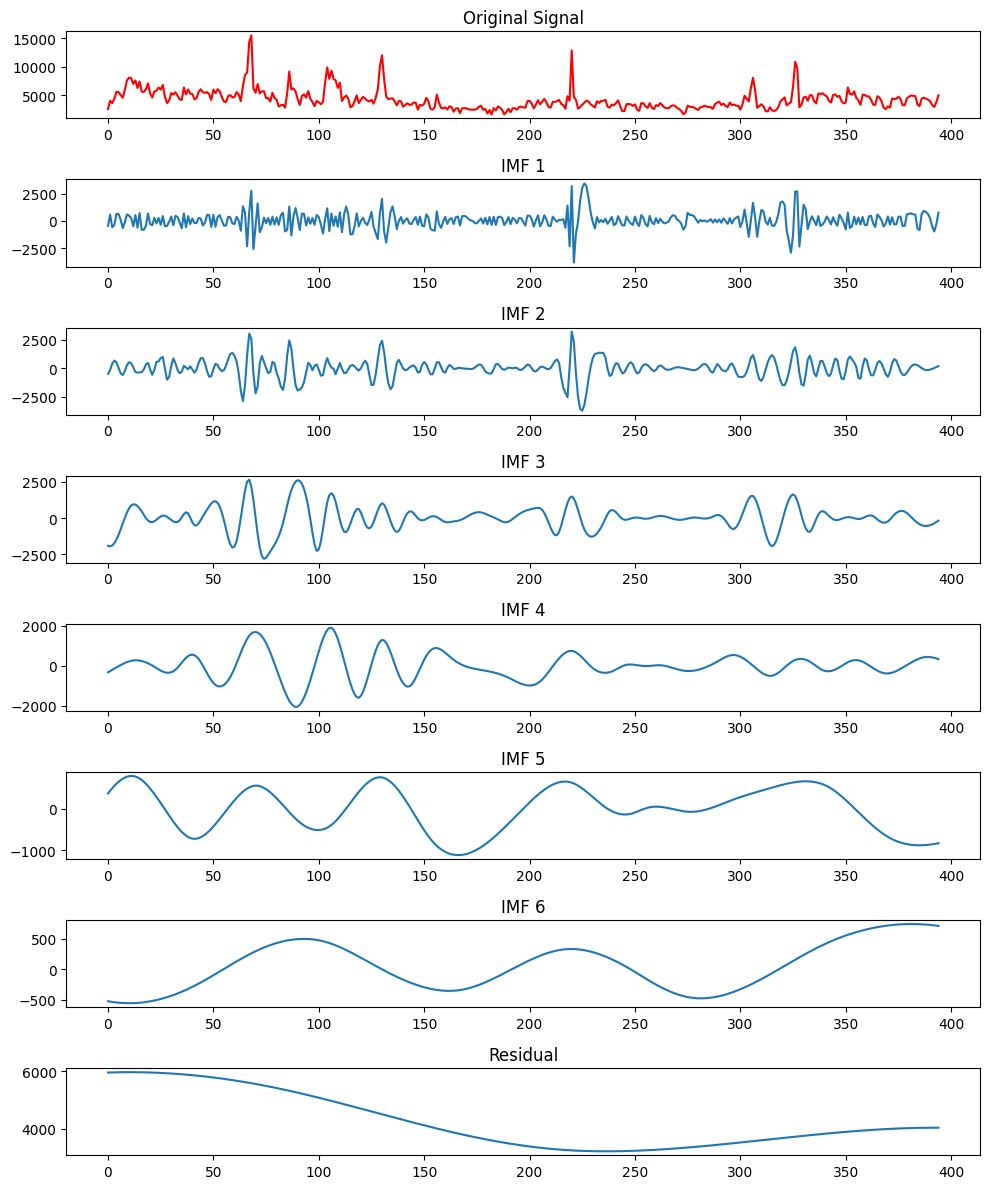

In [5]:
data_source = df_source[labels].values
eIMFs, residue, imfs = lstm.decomposition(data_source, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [6]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.x_scaler.1.pkl 存在，已刪除
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.y_scaler.1.pkl 存在，已刪除
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.1.keras 存在，已刪除
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.x_scaler.2.pkl 存在，已刪除
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.y_scaler.2.pkl 存在，已刪除
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.2.keras 存在，已刪除
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
檔案 DecompEMD/_Model/GroupCount_mt2_data5_batch14.x_scaler.3.pkl 存在，已刪除
檔案 DecompEMD/_Model/GroupCount_mt2_da

# 最小最大正規化

In [7]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)

    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [8]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [9]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [10]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：2
BiLSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [11]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [12]:
for i in range(len(models)):
    print_step(i + 1)   

    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt2_data5_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
-----------------------------

# 預測

In [13]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [14]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [15]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(data_source, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (301, 1)
y_lstm_origin_train.shape : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14, 1)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14, 1)
y_lstm_origin_val.shape : (24, 1)


In [16]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (301, 1)
actual_inverse_train_sum (301, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [17]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_absolute_percentage_error: 12.2779

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - mean_absolute_percentage_error: 930988.2500


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.07345，MAPE:8287996429104.629，MSE:0.01166，RMSE:0.10799，R square:-0.02201
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:535.39437，MAPE:5.53664，MSE:619630.85415，RMSE:787.16634，R square:-0.02201

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mean_absolute_percentage_error: 12.0005

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_absolute_percentage_error: 12.0005


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.05966，MAPE:0.12001，MSE:0.00486，RMSE:0.06974，R square:-0.1042
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:434.86604，MAPE:2.43475，MSE:258444.00677，RMSE:508.37388，R square:-0.1042

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_absolute_percentage_error: 14.0579

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_absolute_percentage_error: 14.0579


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.0718，MAPE:0.14058，MSE:0.0062，RMSE:0.07872，R square:0.01422
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:523.35332，MAPE:0.95402，MSE:329234.39163，RMSE:573.7895，R square:0.01422

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_absolute_percentage_error: 10.3945

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mean_absolute_percentage_error: 471098.7812


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.05427，MAPE:4193833123186.97，MSE:0.00655，RMSE:0.08094，R square:0.58607
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:376.37268，MAPE:2.59138，MSE:315096.56321，RMSE:561.33463，R square:0.58607

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_absolute_percentage_error: 9.2936

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mean_absolute_percentage_error: 9.2936


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.05432，MAPE:0.09294，MSE:0.00519，RMSE:0.07201，R square:0.40051
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:376.70638，MAPE:0.96117，MSE:249426.03243，RMSE:499.4257，R square:0.40051

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mean_absolute_percentage_error: 4.9892

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - mean_absolute_percentage_error: 4.9892


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.02777，MAPE:0.04989，MSE:0.00114，RMSE:0.03375，R square:0.59018
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:192.56459，MAPE:3.59488，MSE:54770.13295，RMSE:234.0302，R square:0.59018

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mean_absolute_percentage_error: 6.3032

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mean_absolute_percentage_error: 296800.8438


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.03137，MAPE:765620114374.2677，MSE:0.00134，RMSE:0.03664，R square:0.95045
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:171.99671，MAPE:2.52407，MSE:40364.47676，RMSE:200.90913，R square:0.95045

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8217e-04 - mean_absolute_percentage_error: 5.5638

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8217e-04 - mean_absolute_percentage_error: 5.5638


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02798，MAPE:0.05564，MSE:0.00088，RMSE:0.0297，R square:0.82641
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:153.38831，MAPE:6.48245，MSE:26519.44999，RMSE:162.84794，R square:0.82641

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_percentage_error: 6.4826

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mean_absolute_percentage_error: 6.4826


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03093，MAPE:0.06483，MSE:0.00104，RMSE:0.03219，R square:0.76139
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:169.57311，MAPE:0.7039，MSE:31153.04309，RMSE:176.50225，R square:0.76139

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6690e-04 - mean_absolute_percentage_error: 1.8488

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0655e-04 - mean_absolute_percentage_error: 33547.0039


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0112，MAPE:114597526354.53082，MSE:0.00019，RMSE:0.01379，R square:0.99456
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:44.2815，MAPE:1.75162，MSE:2969.73138，RMSE:54.49524，R square:0.99456

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8917e-05 - mean_absolute_percentage_error: 1.5263

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8917e-05 - mean_absolute_percentage_error: 1.5263


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00809，MAPE:0.01526，MSE:8e-05，RMSE:0.00888，R square:0.96863
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:31.96173，MAPE:0.51991，MSE:1232.55021，RMSE:35.10769，R square:0.96863

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0803e-05 - mean_absolute_percentage_error: 1.4317

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0803e-05 - mean_absolute_percentage_error: 1.4317


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00767，MAPE:0.01432，MSE:6e-05，RMSE:0.0078，R square:0.98908
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:30.2995，MAPE:0.19021，MSE:949.64457，RMSE:30.8163，R square:0.98908

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0502e-05 - mean_absolute_percentage_error: 1.3495

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2584e-05 - mean_absolute_percentage_error: 24828.5137


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00467，MAPE:136410206357.79362，MSE:3e-05，RMSE:0.00585，R square:0.99947
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:8.94912，MAPE:3.69151，MSE:125.64731，RMSE:11.20925，R square:0.99947

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7007e-05 - mean_absolute_percentage_error: 0.6880

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7007e-05 - mean_absolute_percentage_error: 0.6880


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00509，MAPE:0.00688，MSE:4e-05，RMSE:0.00608，R square:0.99682
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:9.74827，MAPE:0.08904，MSE:135.92746，RMSE:11.65879，R square:0.99682

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0460e-04 - mean_absolute_percentage_error: 6.9758

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0460e-04 - mean_absolute_percentage_error: 6.9758


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01018，MAPE:0.06976，MSE:0.0001，RMSE:0.01023，R square:0.88218
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:19.50288，MAPE:0.02356，MSE:384.20907，RMSE:19.60125，R square:0.88218

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5638e-05 - mean_absolute_percentage_error: 6.2590

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1648e-04 - mean_absolute_percentage_error: 3.7523


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00931，MAPE:0.0343，MSE:0.00011，RMSE:0.01037，R square:0.99813
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:12.01269，MAPE:0.12255，MSE:179.01171，RMSE:13.37953，R square:0.99813

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8608e-04 - mean_absolute_percentage_error: 2.8040

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8608e-04 - mean_absolute_percentage_error: 2.8040


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02172，MAPE:0.02804，MSE:0.00049，RMSE:0.02205，R square:0.92498
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:28.02678，MAPE:0.06527，MSE:809.64608，RMSE:28.45428，R square:0.92498

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 3.9042

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 3.9042


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03874，MAPE:0.03904，MSE:0.0015，RMSE:0.03875，R square:-30.34955
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:50.00136，MAPE:0.06886，MSE:2501.39604，RMSE:50.01396，R square:-30.3495

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5059e-06 - mean_absolute_percentage_error: 0.2109

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8814e-06 - mean_absolute_percentage_error: 15805.6123


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00287，MAPE:106622781971.61638，MSE:1e-05，RMSE:0.00386，R square:0.99989
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:7.9237，MAPE:0.00222，MSE:113.67778，RMSE:10.66198，R square:0.99989

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4521e-05 - mean_absolute_percentage_error: 3.5298

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4521e-05 - mean_absolute_percentage_error: 3.5298


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00802，MAPE:0.0353，MSE:6e-05，RMSE:0.00803，R square:0.77355
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:22.14071，MAPE:0.00576，MSE:491.63306，RMSE:22.1728，R square:0.77355

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0924e-05 - mean_absolute_percentage_error: 2.6616

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0924e-05 - mean_absolute_percentage_error: 2.6616


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00779，MAPE:0.02662，MSE:6e-05，RMSE:0.00781，R square:-1.41426
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:21.4995，MAPE:0.00534，MSE:464.22577，RMSE:21.5459，R square:-1.41426

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:622.54485，MAPE:0.15637，MSE:865157.70016，RMSE:930.13854，R square:0.75069

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:474.65784，MAPE:0.10201，MSE:351621.89021，RMSE:592.97714，R square:0.31232

------------------------------------------------------------------------
合併後 Test Evaluate
------------------------------------------------------------------------
A

# 顯示預測圖表

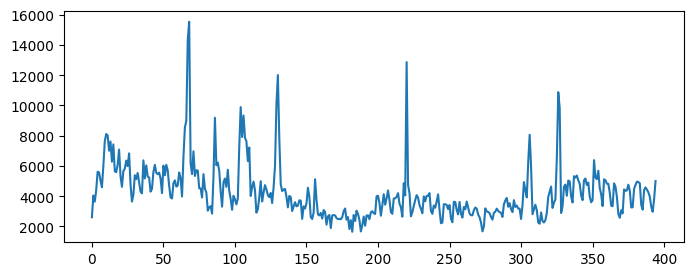

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(data_source)
plt.show()

## 訓練集

原始資料 (316, 1)
[[2178]
 [2917]
 [2357]]
原始資料2 (301, 1)
[[2178]
 [2917]
 [2357]]
還原原始資料 (301, 1)
[[3631.388859  ]
 [3639.25399655]]


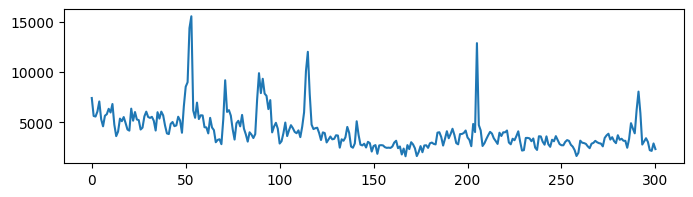

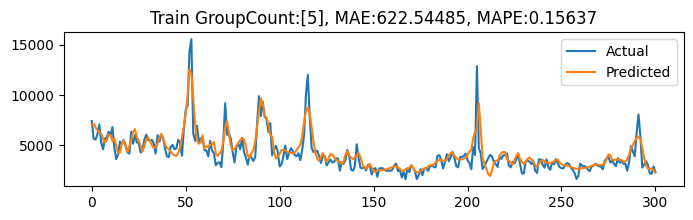

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39, 1)
[[5237]
 [5122]
 [5679]]
原始資料2 (24, 1)
[[5237]
 [5122]
 [5679]]
還原原始資料 (24, 1)
[[3911.13292997]
 [3916.92507234]]


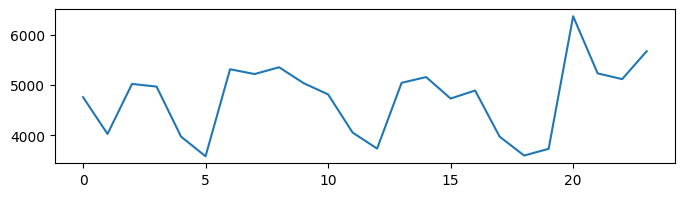

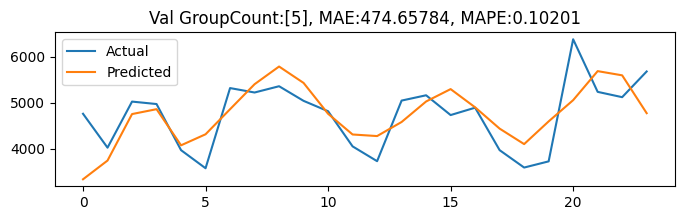

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40, 1)
[[2964]
 [3799]
 [5001]]
原始資料2 (25, 1)
[[2964]
 [3799]
 [5001]]
還原原始資料 (25, 1)
[[4038.02006576]
 [4037.92555604]]
Test GroupCount:[5], BatchSize:14, MAE:515.30824, MAPE:0.13573


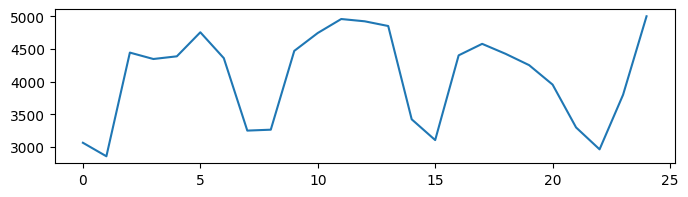

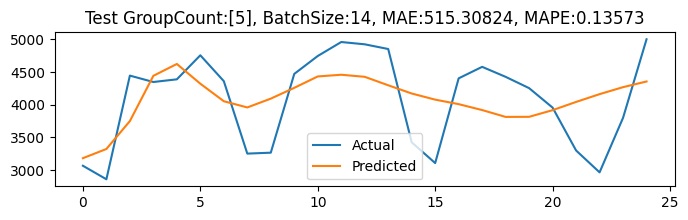

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'DecompEMD', 'labels': ['GroupCount'], 'model_type': 2, 'predicteds': [5], 'batch_size': 14, 'train_mae': 622.54485, 'train_mape': 0.15637, 'test_mae': 515.30824, 'test_mape': 0.13573, 'kfold': None, 'imfs': 7}
儲存評估結果到 DecompEMD/_Model/GroupCount_mt2_data5_batch14.result.json
